# Project 1: Classification, weight sharing, auxiliary losses 


The objective of this project is to test different architectures to compare two digits visible in a
two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an
auxiliary loss to help the training of the main objective.
It should be implemented with PyTorch only code, in particular without using other external libraries
such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second. The training and test set should be 1, 000 pairs each, and the size of the images allows to run experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate˙pair˙sets(N) defined in the file
dlc˙practical˙prologue.py. This function returns six tensors:

## Set-up: 

In [1]:
import matplotlib.pyplot as plt

In [1]:
import sys
sys.path.append('/Users/marijnvandermeer/opt/anaconda3/envs/env_pytorch/lib/python3.6/site-packages')


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import argparse
import os
import urllib
import torch.nn as nn

import matplotlib.pyplot as plt
from dlc_practical_prologue import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from signSGD import signSGD
from Nadam import Nadam

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [19]:
# control the randomness
torch.manual_seed(0)

In [20]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [21]:
if not os.path.exists('../data/'):
    os.makedirs('../data/')

In [22]:
# Run this once to download the MNIST data-set. 
# There is a problem with the server on which it's hosted so only way right now 
# to have it :( 
'''
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
'''

'\n!wget www.di.ens.fr/~lelarge/MNIST.tar.gz\n!tar -zxvf MNIST.tar.gz\n'

## Data: 

In [23]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(
    1000)

In [24]:
print(f'Training and test input size: {train_input.size(), test_input.size()}')
print(f'Training and test target size: {train_target.size(), test_target.size()}')
print(f'Training and test classes size: {train_classes.size(), test_classes.size()}')

Training and test input size: (torch.Size([1000, 2, 14, 14]), torch.Size([1000, 2, 14, 14]))
Training and test target size: (torch.Size([1000]), torch.Size([1000]))
Training and test classes size: (torch.Size([1000, 2]), torch.Size([1000, 2]))


Generate dataset needed for training. For this as we have a special data case we rewrite the `Dataset` class in order to use a `dataloader` later. Remember `target` is 1 if first number is smaller or equal than the second image.  

In [25]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, pairs, target, classes):
        'Initialization'
        # target = (0,1)
        self.target = target
        # image pairs (2,14,14)
        self.pairs = pairs
        # cipher classes (2 in [0,9])
        self.classes = classes

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.pairs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # image pairs
        X = self.pairs[index]
        # target:
        y = self.target[index]
        # classes:
        Y = self.classes[index]
        return X, y, Y

Create datasets (training and validation):

In [26]:
training_set = Dataset(train_input, train_target, train_classes)
test_set = Dataset(test_input, test_target, test_classes)

Have a look:

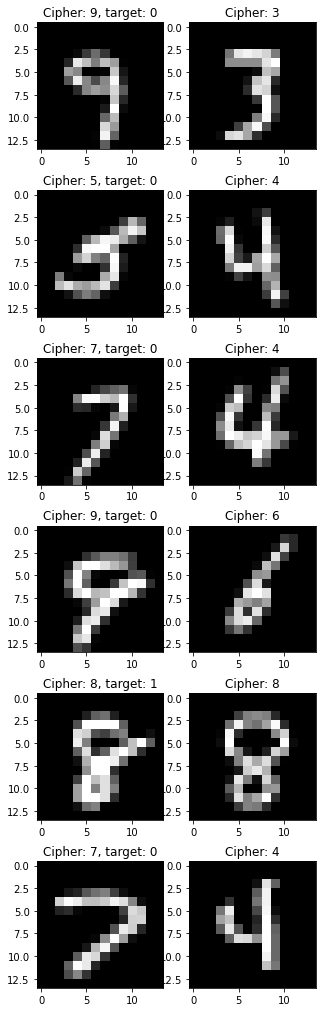

In [27]:
fig, ax = plt.subplots(6, 2, figsize=(5, 18))
for j in range(6):
    im1 = training_set.__getitem__(j)[0][0, :, :]
    im2 = training_set.__getitem__(j)[0][1, :, :]
    target = training_set.__getitem__(j)[1]
    classes = training_set.__getitem__(j)[2]
    ax[j, 0].imshow(im1, cmap='gray')
    ax[j, 1].imshow(im2, cmap='gray')
    ax[j, 1].set_title(f'Cipher: {classes[1]}')
    ax[j, 0].set_title(f'Cipher: {classes[0]}, target: {target}')

## Models:

### Model architectures:

#### Baseline: 
- Loss: CE (cross entropy) 
- Optimizer: SGD optimizer
- Activation function: softmax

In [34]:
# Basic model with two layers and a two digit output:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 2 * 14 * 14
        hidden_sizes = [392, 392]
        # two digit output, probability of being 1 or 0:
        output_size = 2
        # flatten images to 1D input:
        self.flatten = nn.Flatten()
        # then two hidden layers:
        self.model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                   nn.ReLU(),
                                   nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                   nn.ReLU(),
                                   nn.Linear(hidden_sizes[1], output_size))
        # no need to add softmax at the end because already in CE loss.
    def forward(self, x):
        # flatten 2D->1D
        x = self.flatten(x)
        print(x.shape)
        # predict probabilities:
        logits = self.model(x)
        print(logits.shape)
        return logits

### Train model:

##### Load data:

In [35]:
# Data loader for model, change num_workers when on GPU:
params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}
training_generator = torch.utils.data.DataLoader(training_set, **params)
test_generator = torch.utils.data.DataLoader(test_set, **params)

##### Call model: 

In [36]:
model = Model_1().to(device)
print(model)

Model_1(
  (flatten): Flatten()
  (model): Sequential(
    (0): Linear(in_features=392, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=2, bias=True)
  )
)


##### Training:
Binary classification with two output units --> so `CrossEntropyLoss()` so need to use `torch.nn.CrossEntropyLoss` instead of `BCELoss` (BCE for 1 digit output). The `Softmax` activation is already included in this loss function. 

In [37]:
from sklearn.metrics import roc_auc_score


def train_loop(dataloader, model, loss_fn, optimizer, print_values = False):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y, Y) in enumerate(dataloader):
        # Compute prediction and loss:
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            if print_values:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # return average training loss:
    train_loss /= size
    return train_loss


def test_loop(dataloader, model, loss_fn, F1 = True, print_values = True):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    tp, fp, fn, tn, = 0, 0, 0, 0
    softmax = torch.nn.Softmax(dim=1)
    roc = 0
    with torch.no_grad():
        for X, y, Y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # Softmax to get probabilities:
            prob = softmax(pred)
            # calculate number of correct predictions:
            correct += (prob.argmax(1) == y).type(torch.float).sum().item()

            # true positives and other rates:
            tp += (prob.argmax(1) * y).type(torch.float).sum().item()
            tn += ((1 - prob.argmax(1)) * (1 - y)).type(
                torch.float).sum().item()
            fp += ((1 - y) * prob.argmax(1)).sum().type(
                torch.float).sum().item()
            fn += (y * (1 - prob.argmax(1))).sum().type(
                torch.float).sum().item()
            roc += roc_auc_score(y, prob.argmax(1))
            
    # return average test loss and accuracy:
    test_loss /= size
    correct /= size
    roc /= size

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    if F1 and print_values: 
        print(
            f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, F1: {(100*f1):>0.1f}%, ROC: {roc:>8f}, Avg loss: {test_loss:>8f} \n"
        )
    elif print_values: 
         print(
            f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        )
    return 100 * correct, 100*f1, test_loss, roc

Hyperparameters and optimizers:

In [38]:
learning_rate = 1e-3
batch_size = 64
epochs = 25

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [39]:
training_loss, test_loss = [], []
accuracy, f1 = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(training_generator, model, loss_fn, optimizer)
    acc, f1_, t_loss, roc = test_loop(test_generator, model, loss_fn)
    accuracy.append(acc)
    f1.append(f1_)
    training_loss.append(train_loss)
    test_loss.append(t_loss)
print("Done!")

# save model:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '../data/baseline.pt')

Epoch 1
-------------------------------
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([40, 392])
torch.Size([40, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64, 2])
torch.Size([64, 392])
torch.Size([64

KeyboardInterrupt: 

Plot losses and accuracy:

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(8, 4))
axs[0].plot(accuracy, label = 'accuracy')
axs[0].plot(f1, label = 'F1 score')
axs[0].set_xlabel('Num epochs')
axs[0].set_title('Evaluation metrics')
axs[1].plot(test_loss, label=' test_loss')
axs[1].plot(training_loss, label='train_loss')
axs[1].set_xlabel('Num epochs')
axs[1].set_title('Loss')
axs[1].legend()
axs[0].legend()

### Training with different optimizers:

Optimizer: SGD
Done!
-------------------------------
Optimizer: RMSprop
Done!
-------------------------------
Optimizer: Adam
Done!
-------------------------------
Optimizer: signSGD
Done!
-------------------------------
Optimizer: Nadam
Done!
-------------------------------


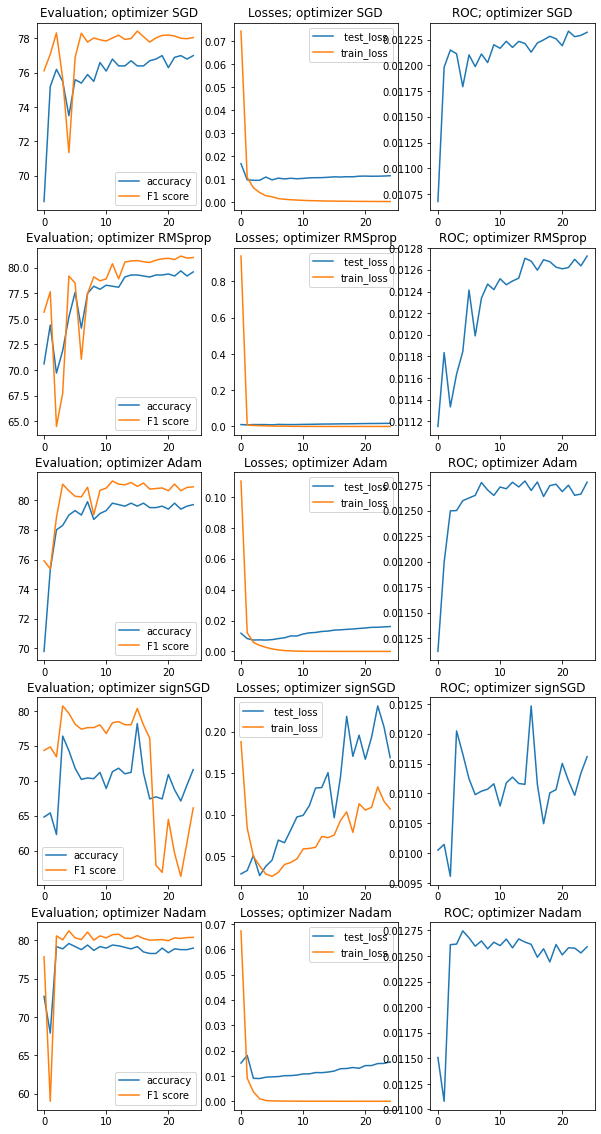

In [24]:
fig, axs = plt.subplots(5, 3, figsize=(10, 20))

optimizers = {
    'SGD':(torch.optim.SGD, {'lr':learning_rate, 'nesterov':True, 'momentum':0.5}),
    'RMSprop':(torch.optim.RMSprop, {'lr':learning_rate}),
    'Adam':(torch.optim.Adam, {'lr':learning_rate}),
    'signSGD':(signSGD, {'lr':learning_rate}),
    'Nadam': (Nadam, {'lr':learning_rate})
}

original_model = Model_1().to(device)

i = 0
for name, (optimizer, kwargs) in optimizers.items():
    print(f"Optimizer: {name}")
    training_loss, test_loss = [], []
    accuracy, f1, roc = [], [], []
    curr_model = Model_1().to(device)
    curr_model.load_state_dict(original_model.state_dict())
    optimizer=optimizer(curr_model.parameters(), **kwargs)
    
    for t in range(epochs):
        train_loss = train_loop(training_generator, curr_model, loss_fn, optimizer, print_values = False)
        acc, f1_, t_loss, roc_ = test_loop(test_generator, curr_model, loss_fn, print_values = False)
        accuracy.append(acc)
        f1.append(f1_)
        roc.append(roc_)
        training_loss.append(train_loss)
        test_loss.append(t_loss)
    print("Done!\n-------------------------------")
    axs[i, 0].plot(accuracy, label='accuracy')
    axs[i, 0].plot(f1, label='F1 score')
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_title(f'Evaluation; optimizer {name}')
    axs[i, 1].plot(test_loss, label=' test_loss')
    axs[i, 1].plot(training_loss, label='train_loss')
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_title(f'Losses; optimizer {name}')
    axs[i, 1].legend()
    axs[i, 0].legend()
    axs[i,2].plot(roc)
    axs[i,2].set_title(f'ROC; optimizer {name}')

    i += 1

### Predictions on test set:

torch.Size([64, 392])
torch.Size([64, 2])


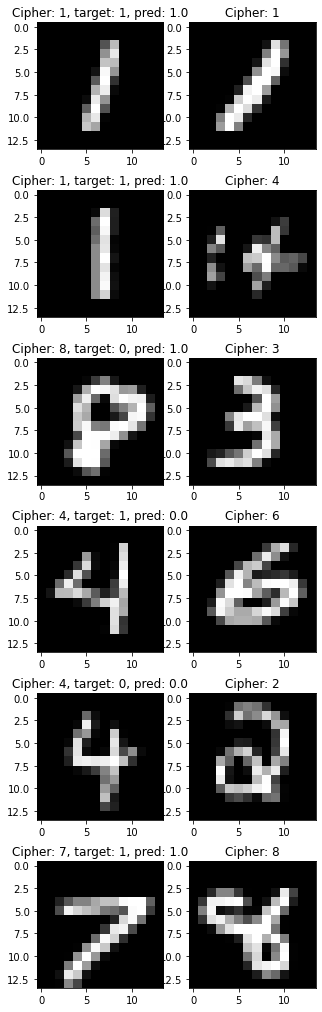

In [42]:
# Make a few predictions:
size = len(test_generator.dataset)
softmax = torch.nn.Softmax(dim=1)
fig, ax = plt.subplots(6, 2, figsize=(5, 18))

with torch.no_grad():
    for batch, (X, y, Y) in enumerate(test_generator):
        if batch == 0:
            pred = model(X)
            prob = softmax(pred)
            prediction = prob.argmax(1).type(torch.float)
            for j in range(6):
                im1 = X[j][0, :, :]
                im2 = X[j][1, :, :]
                target = y[j]
                classes = Y[j]
                pred = prediction[j]
                ax[j, 0].imshow(im1, cmap='gray')
                ax[j, 1].imshow(im2, cmap='gray')
                ax[j, 0].set_title(
                    f'Cipher: {classes[0]}, target: {target}, pred: {pred}')
                ax[j, 1].set_title(f'Cipher: {classes[1]}')